In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, clear_output
from time import sleep
from livelossplot import PlotLosses
import tensorflow as tf
import numpy as np
import seaborn as sns; 
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from scipy.stats import norm, uniform
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm
import sys
sys.path.append('../models/')
sys.path.append('../')
from ratio_utils import *

print(tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.15.0


In [13]:
num_samples = 1000
N=500
deep=False
reset(4)

def get_data(mu_1=0.,mu_2=2.,mu_3=2.,scale_p=0.1,scale_q=0.1,scale_m=1.,mtype="mix"):
    
    p = tfd.Normal(loc=mu_1, scale=scale_p)
    q = tfd.Normal(loc=mu_2, scale=scale_q) 
    if mtype=='cauchy':
        m = tfp.distributions.Cauchy(loc=mu_3, scale=scale_m)
    elif mtype=='mix':
        m = tfp.distributions.Mixture(
          cat=tfp.distributions.Categorical(probs=[.5,.5]),
          components=[
            p,
            q
        ])
    elif mtype=='student':
        m = tfp.distributions.StudentT(df=1., loc=mu_3, scale=scale_m)
    else:
        m = tfp.distributions.Normal(loc=mu_3, scale=scale_m)
        
    p_samples_ = p.sample([num_samples]) 
    q_samples_ = q.sample([num_samples])
#     alpha = tfd.Uniform (0.,1.).sample([bs])
    m_samples_ = m.sample([num_samples]) #tf.sqrt(1-alpha*alpha)*p_samples + alpha*q_samples + m.sample([bs])
    
    with tf.Session() as sess:
        p_,q_,m_ = sess.run([p_samples_, q_samples_, m_samples_],feed_dict={})
        sess.close() 
    
    return p, q, m, p_,q_,m_

mu_1=0.
mu_2=0.
mu_3=0.

scale_p=1e-6
scale_q=1.
scale_m=1.

# Generate dataset
p, q, m, p_list, q_list, m_list = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)
_, _, _, p_list_test, _, m_list_test = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)

print(p_list.shape)

(1000,)


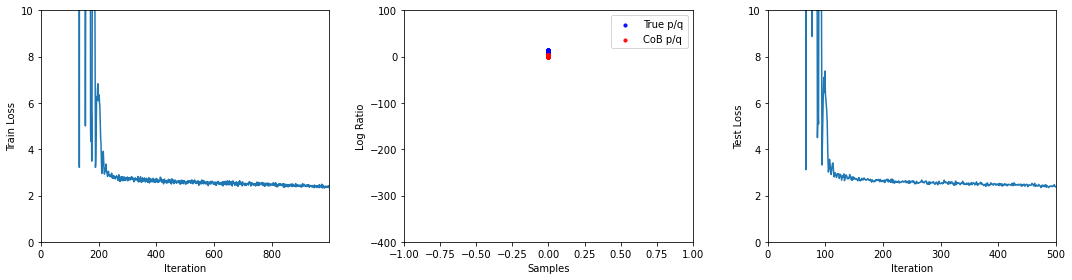

KLD:  13.364033
CoB:  1.8327986


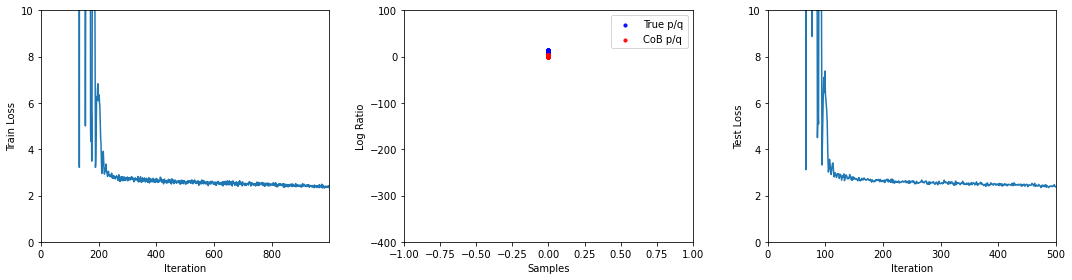

In [14]:
p_samples = tf.placeholder(tf.float32, shape=[None])
q_samples = tf.placeholder(tf.float32, shape=[None])
m_samples = tf.placeholder(tf.float32, shape=[None])

dloss = get_loss(p_samples, q_samples, m_samples, None, deep=deep)
optim = get_optim(dloss,lr=1e-2) #,lr=5e-3,b1=.99

log_ratio_p_q, _, kld = get_gt_ratio_kl(p,q,m_samples)
_, kl_from_pq, _ = get_gt_ratio_kl(p,q,p_samples)
kl_from_cob = get_kl_from_cob(p_samples)

log_ratio_p_m = get_logits(m_samples,deep=deep, training=False)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

loss_store=[]
test_loss_store=[]
fig, [ax1,ax2,ax3] = plt.subplots(1, 3,figsize=(15,4))

line, = ax1.plot([0,1],[0,1])
x, y = np.random.random((2, 500))
scat1 = ax2.scatter(x,y,label='True p/q',alpha=0.9,s=10.,c='b')
scat2 = ax2.scatter(x,y,label='CoB p/q',alpha=0.9,s=10.,c='r')
test_line, = ax3.plot([0,1],[0,1])

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Train Loss")
ax1.set_xlim([0,N])
ax1.set_ylim([0,10])

ax2.set_xlabel("Samples")
ax2.set_ylabel("Log Ratio")
ax2.legend(loc='best')
ax2.set_xlim([-6,10])
ax2.set_ylim([-1500,5000])

ax3.set_xlabel("Iteration")
ax3.set_ylabel("Test Loss")
ax3.set_xlim([0,N])
ax3.set_ylim([0,10])

plt.tight_layout()

pbar = range(0,N)
for j in pbar:
    for i in range(num_samples//bs):

        ps = p_list[np.random.choice(range(len(p_list)),bs)]
        qs = q_list[np.random.choice(range(len(q_list)),bs)]
        ms = m_list[np.random.choice(range(len(m_list)),bs)]
        feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}
        l,_ = sess.run([dloss, optim],feed_dict=feed_dict)
        loss_store.append(l)
        if i%50==0:
            line.set_data(range(len(loss_store)), loss_store)
            ax1.set_xlim( 0, len(loss_store) )

            ps = p_list_test[np.random.choice(range(len(p_list_test)),bs)]
            qs = q_list[np.random.choice(range(len(q_list)),bs)]
            ms = m_list_test[np.random.choice(range(len(m_list_test)),bs)]
            feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}

            testl, xs, lpq, lpqm, kld_true, kld_cob = sess.run([dloss,m_samples, log_ratio_p_q, log_ratio_p_m, kl_from_pq, kl_from_cob],feed_dict=feed_dict)

            scat2.set_offsets(np.asarray([xs,lpqm[:,0]-lpqm[:,1]]).T)
            scat1.set_offsets(np.asarray([xs, lpq]).T)
            ax2.set_xlim( -1., 1. )
            ax2.set_ylim( -400, 100 )
            
            test_loss_store.append(testl)
            test_line.set_data(range(len(test_loss_store)), test_loss_store)
            ax3.set_xlim( 0, len(test_loss_store) )
            print('epoch: ',j)
            print('KLD: ', kld_true)
            print('CoB: ', kld_cob)
            clear_output(wait=True)
            display(fig)
            
print('KLD: ', kld_true)
print('CoB: ', kld_cob)

In [ ]:
sample_and_plot(sess, kld, kl_from_pq, kl_from_cob, p_samples, q_samples, m_samples, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m)

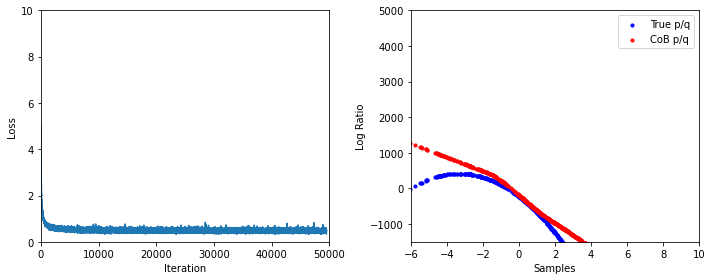

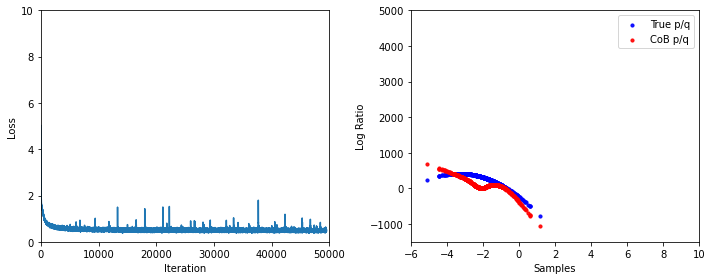

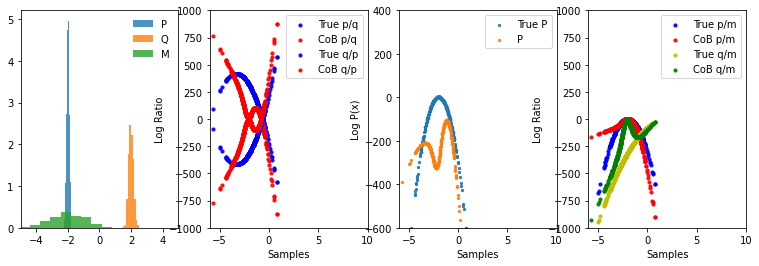

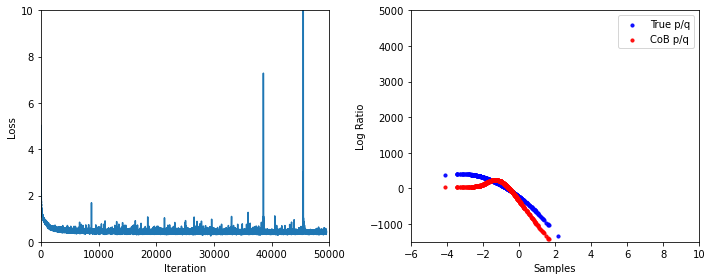

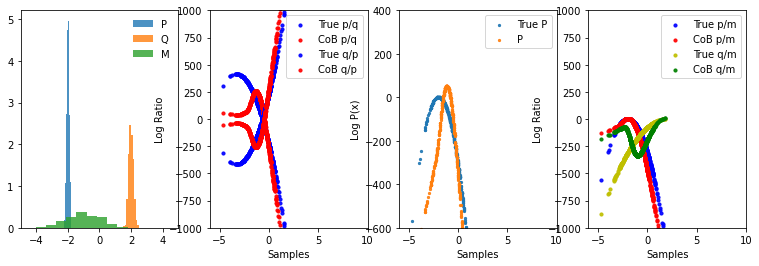

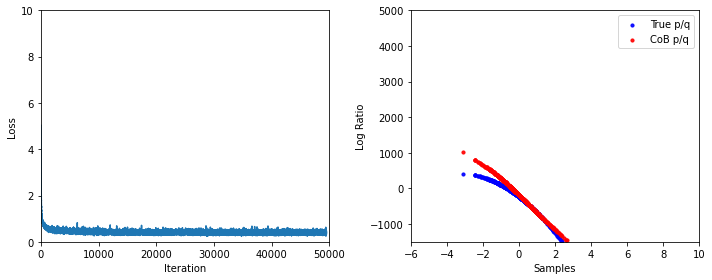

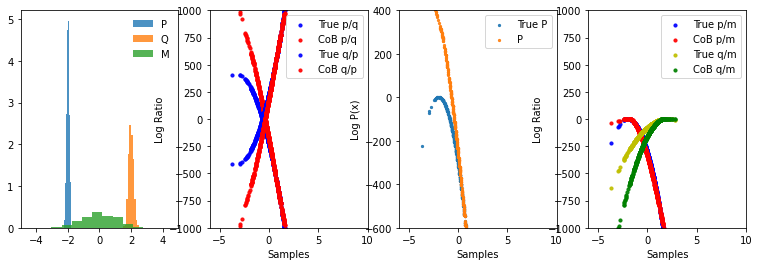

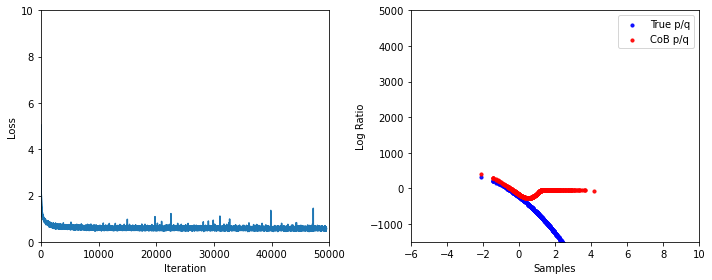

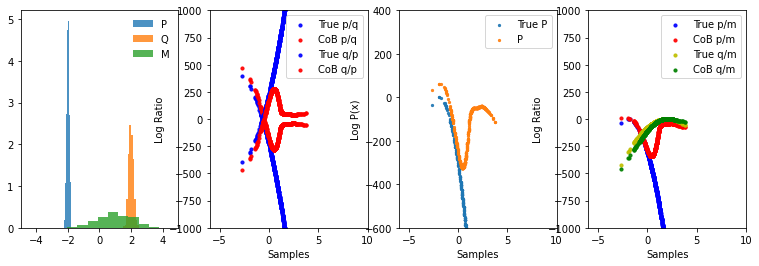

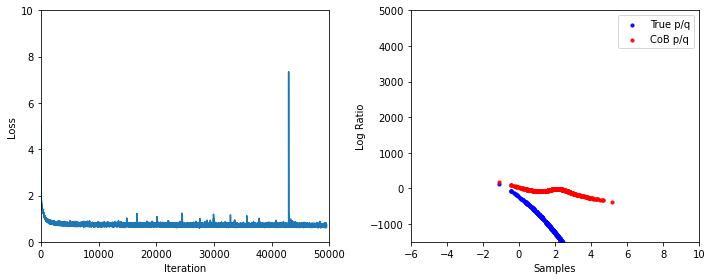

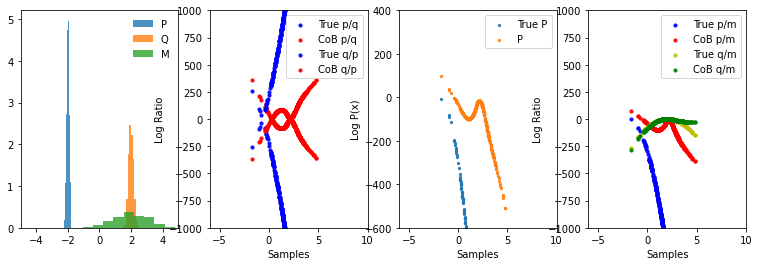

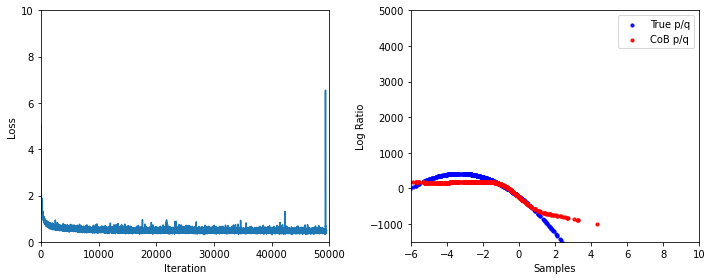

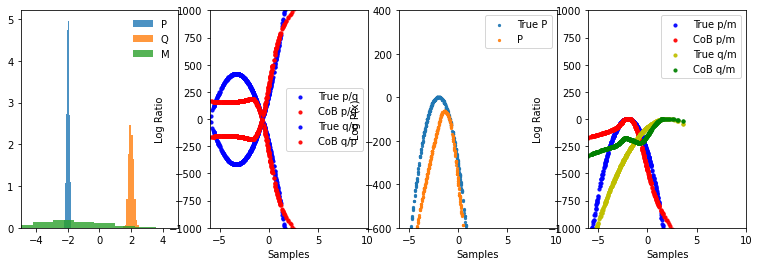

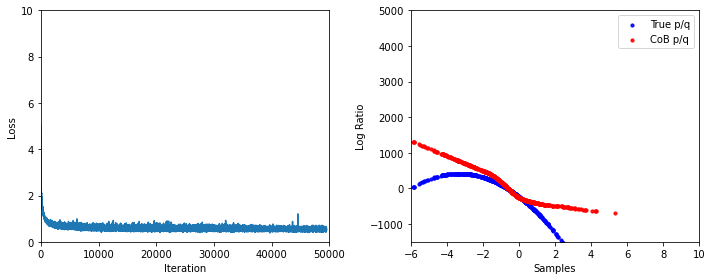

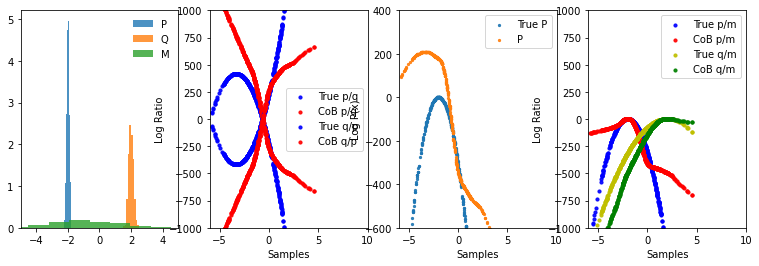

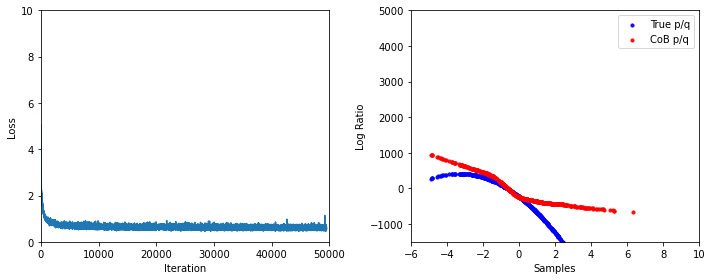

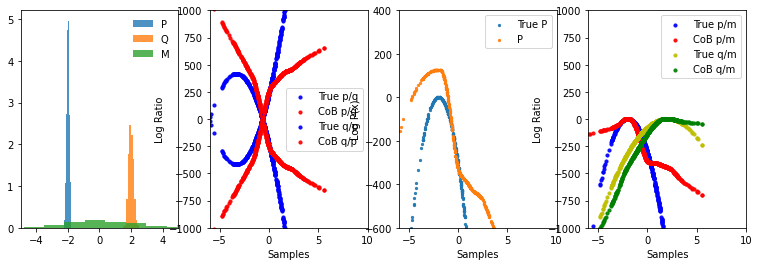

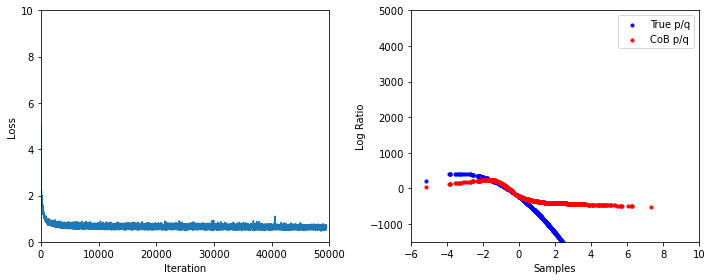

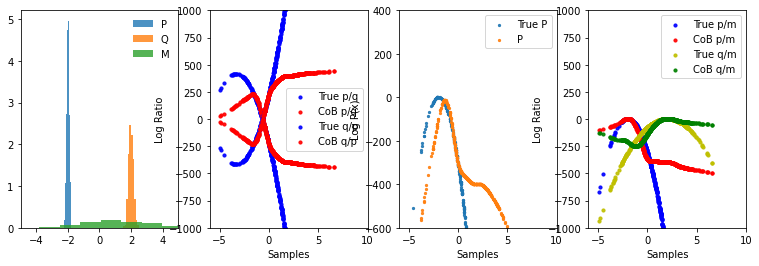

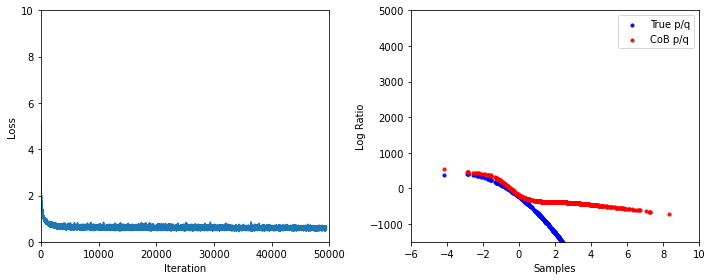

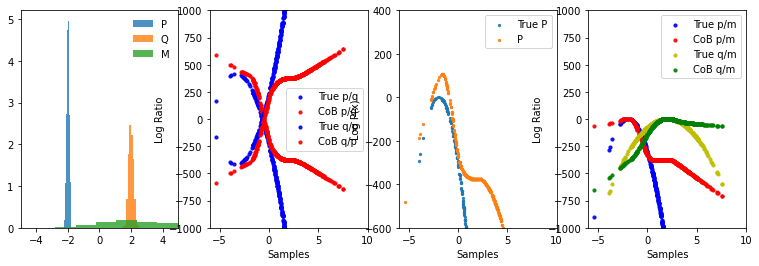

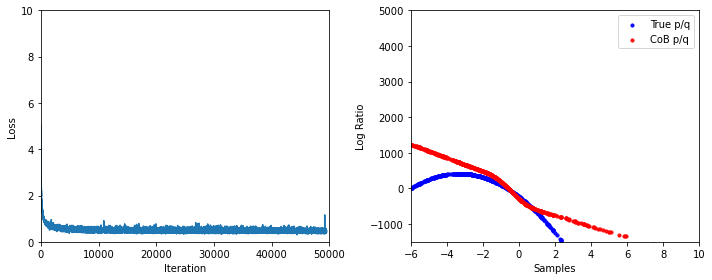

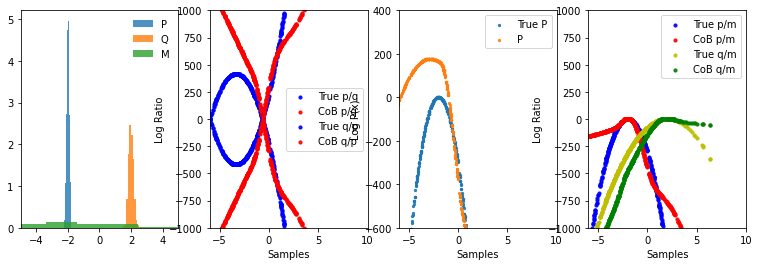

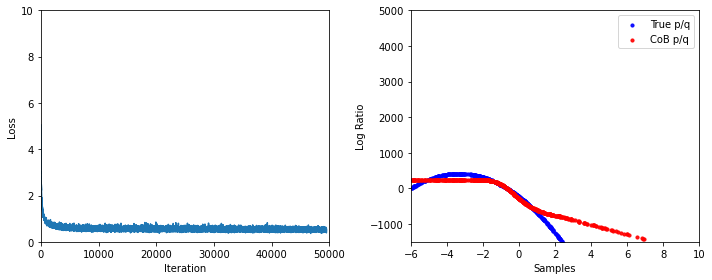

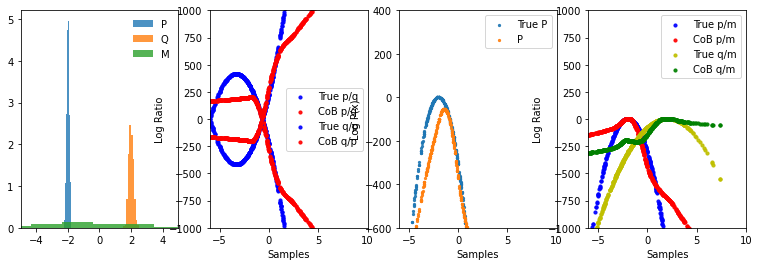

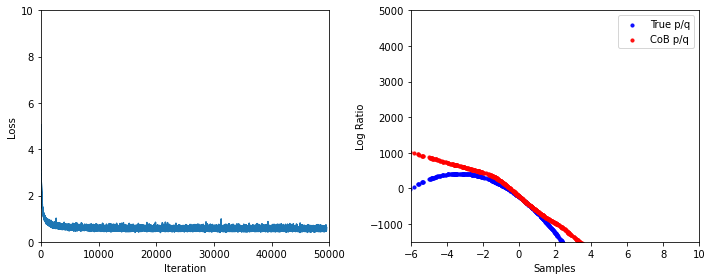

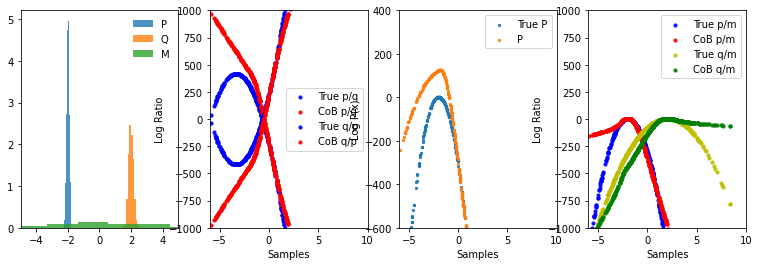

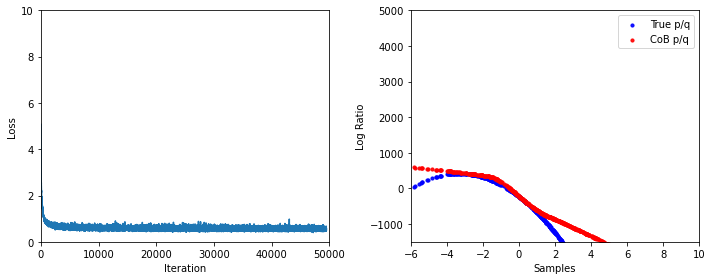

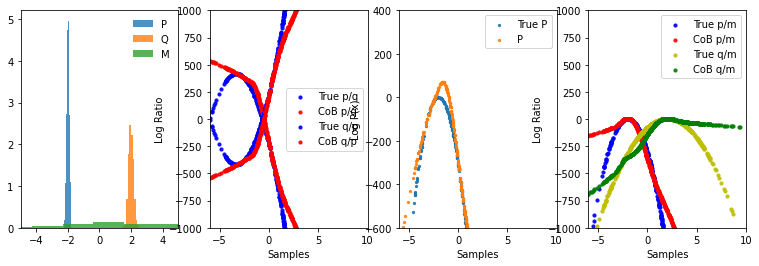

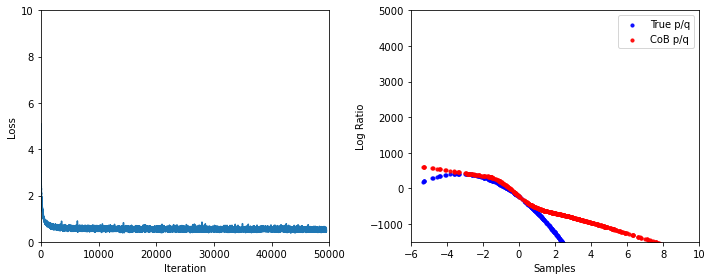

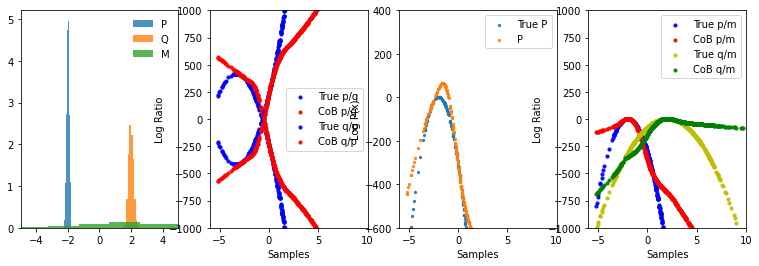

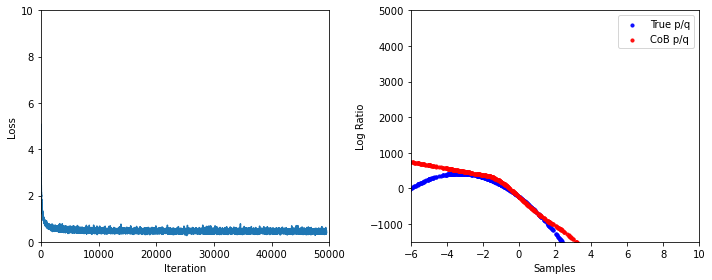

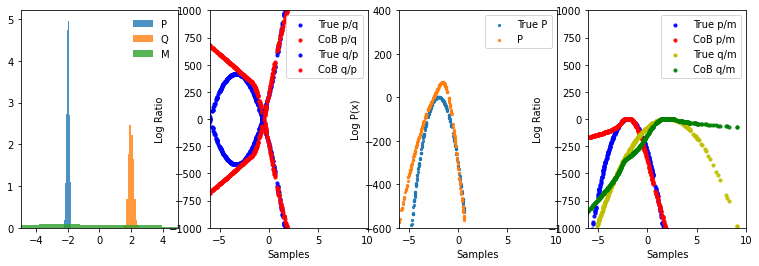

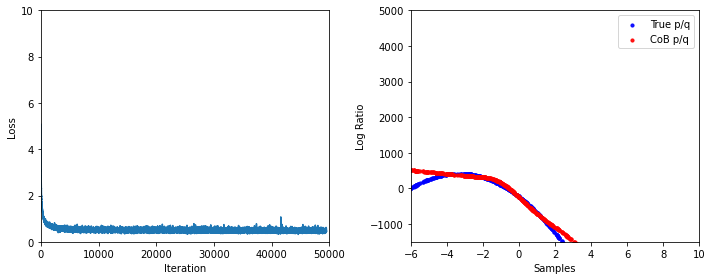

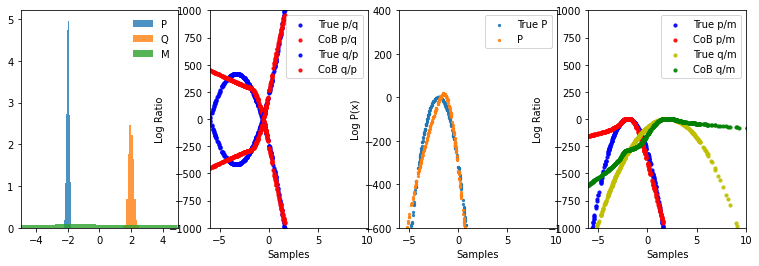

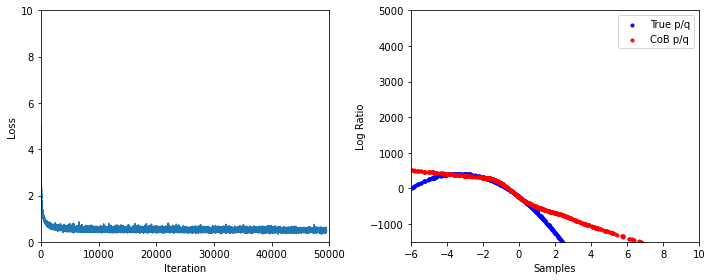

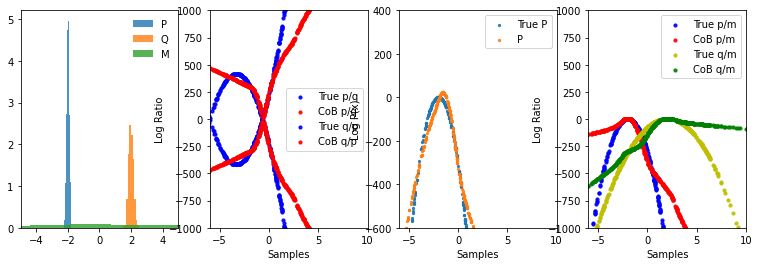

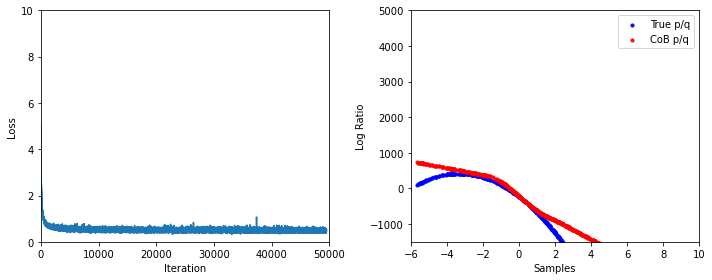

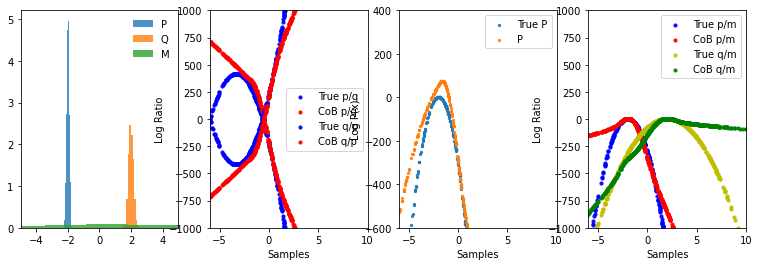

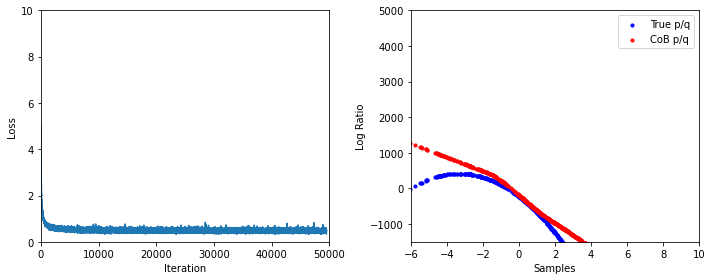

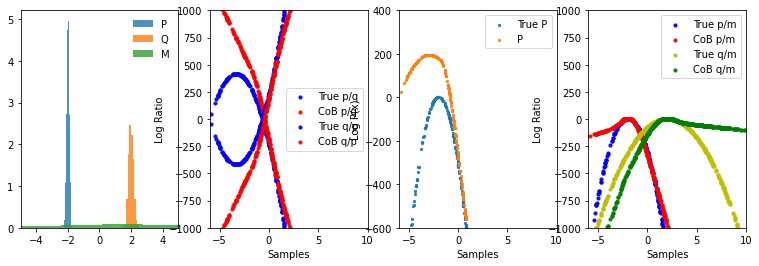

In [3]:
# %matplotlib widget
for j in range(1,5):
    for i in range(-2,3):
        reset(4)

        mu_1=-2.
        mu_2=2.
        mu_3=float(i)
        scale_q=0.16
        scale_p=0.08
        scale_m=float(j)
        N=50000
        deep=False

        p, q, m, p_samples, q_samples, m_samples, m_dist = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)
        dloss = get_loss(p_samples, q_samples, m_samples, None, deep=deep)
        optim = get_optim(dloss,lr=1e-3) #,lr=5e-3,b1=.99

        log_ratio_p_q, _, kld = get_gt_ratio_kl(p,q,m_samples)
        _, kl_from_pq, _ = get_gt_ratio_kl(p,q,p_samples)
        kl_from_cob = get_kl_from_cob(p_samples)

        log_ratio_p_m = get_logits(m_samples,deep=deep, training=False)

        init = tf.global_variables_initializer()
        sess = tf.Session()
        sess.run(init)

        loss_store=[]
        fig, [ax1,ax2] = plt.subplots(1, 2,figsize=(10,4))

        line, = ax1.plot([0,1],[0,1])
        x, y = np.random.random((2, 500))
        scat1 = ax2.scatter(x,y,label='True p/q',alpha=0.9,s=10.,c='b')
        scat2 = ax2.scatter(x,y,label='CoB p/q',alpha=0.9,s=10.,c='r')

        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Loss")
        ax1.set_xlim([0,N])
        ax1.set_ylim([0,10])

        ax2.set_xlabel("Samples")
        ax2.set_ylabel("Log Ratio")
        ax2.legend(loc='best')
        ax2.set_xlim([-6,10])
        ax2.set_ylim([-1500,5000])

        plt.tight_layout()

        pbar = range(0,N)
        for i in pbar:

            feed_dict = {}
            l,_ = sess.run([dloss, optim],feed_dict=feed_dict)
            loss_store.append(l)
            if i%500==0:
                line.set_data(range(len(loss_store)), loss_store)
                xs, lpq, lpqm = sess.run([m_samples, log_ratio_p_q, log_ratio_p_m],feed_dict={})
                scat1.set_offsets(np.asarray([xs, lpq]).T)
                scat2.set_offsets(np.asarray([xs,lpqm[:,0]-lpqm[:,1]]).T)



                clear_output(wait=True)
                display(fig)


        sample_and_plot(sess, kld, kl_from_pq, kl_from_cob, p_samples, q_samples, m_samples, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m)



    

(-1500.0, 1500.0)

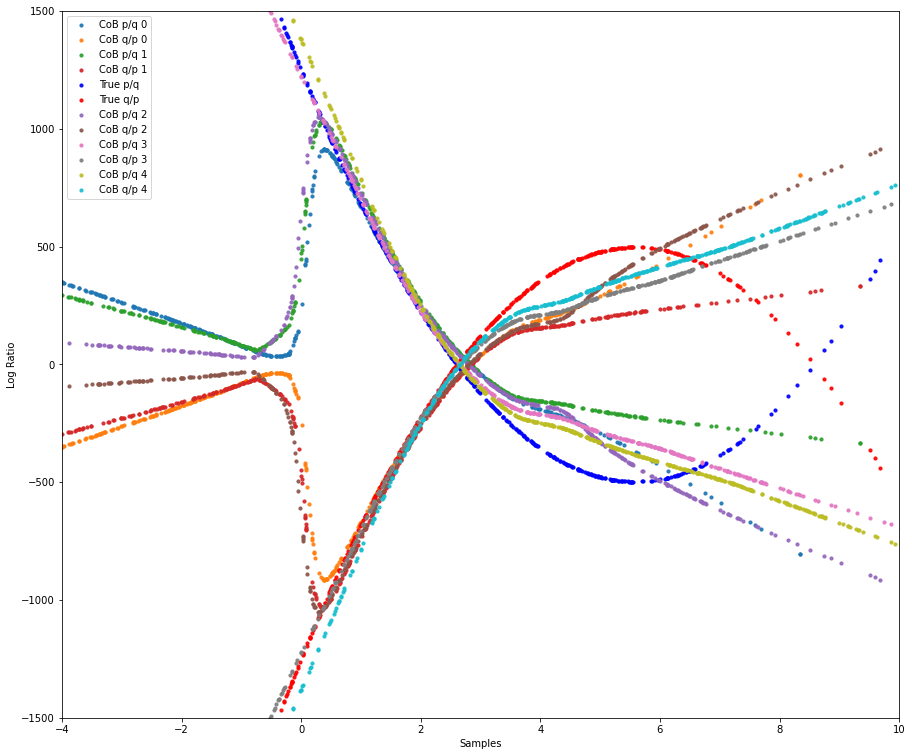

In [17]:
fig, ax2 = plt.subplots(figsize=(15,13))  
for i in range(5):
    data_dir = "../data/"+str(float(i))+"/"
    xs = pickle.load(open(data_dir+"xs"+str(i)+".0.p",'rb'))
    log_ratio_store = pickle.load(open(data_dir+"log_ratio_store"+str(i)+".0.p",'rb'))
    log_r_p_from_m_direct_store = pickle.load(open(data_dir+"log_r_p_from_m_direct_store"+str(i)+".0.p",'rb'))
    if i==2:
        ax2.scatter(xs,log_ratio_store[0],label='True p/q',alpha=0.9,s=10.,c='b')
        ax2.scatter(xs,-log_ratio_store[0],label='True q/p',alpha=0.9,s=10.,c='r')
    
    ax2.scatter(xs,log_r_p_from_m_direct_store[-1][:,0]-log_r_p_from_m_direct_store[-1][:,1],label='CoB p/q '+str(i),alpha=0.9,s=10.)
    ax2.scatter(xs,log_r_p_from_m_direct_store[-1][:,1]-log_r_p_from_m_direct_store[-1][:,0],label='CoB q/p '+str(i),alpha=0.9,s=10.)

ax2.set_xlabel("Samples")
ax2.set_ylabel("Log Ratio")
ax2.legend(loc='best')
ax2.set_xlim([-4,10])
ax2.set_ylim([-1500,1500])

In [ ]:
reset()

mu_1=-2.
mu_2=2.
mu_3=0.
scale_p=0.1
scale_q=0.1
scale_m=1.
N=20000

p, q, m, p_samples, q_samples, m_samples, m_dist = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)
dloss = get_loss(p_samples, q_samples, m_samples, m_dist)
optim = get_optim(dloss)
 
log_ratio_p_q, kld = get_gt_ratio_kl(p,q,m_samples)
log_ratio_p_m = get_logits(m_samples)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

%matplotlib inline
plotlosses = PlotLosses()
train(sess, dloss, optim, plotlosses, N=N)
sample_and_plot(sess, kld, p_samples, q_samples, m_samples, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m)